In [1]:
from tensorflow.keras.models import load_model
import nibabel as nib
# from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nrrd
import slicerio
import os
import tensorflow as tf
import glob

## Metrics and Loss Functions

In [2]:
from tensorflow.keras.metrics import MeanIoU

def iou_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def f1_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    precision = intersection / (K.sum(y_pred_f) + smooth)
    recall = intersection / (K.sum(y_true_f) + smooth)
    return 2 * (precision * recall) / (precision + recall + smooth)

In [3]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5*tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)

# Constants


In [ ]:
# Define constants
HOUNSFIELD_MAX = 1300
HOUNSFIELD_MIN = 150
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = False
SLICE_Y = False
SLICE_Z = True

IMAGE_HEIGHT =128
IMAGE_WIDTH =128

IMG_SIZE =(IMAGE_HEIGHT,IMAGE_WIDTH)

MODEL_NAME = 'UNET_improved_regularized.h5'

## Noramalization

In [5]:
def normalizeImageIntensityRange(img):
    img[img>HOUNSFIELD_MAX]=HOUNSFIELD_MAX
    img[img<HOUNSFIELD_MIN]=HOUNSFIELD_MIN
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

## Read mask [.nrrd]

In [6]:
def readmask(maskpath):
    segmentation_info = slicerio.read_segmentation(maskpath)
    segment_names = slicerio.segment_names(segmentation_info)
    print(f'Segment Names : {segment_names}')
        
    extracted_voxels = slicerio.extract_segments(
    segmentation_info, [(segment_names[0], 1)])
    return extracted_voxels['voxels']

## Input Paths

In [7]:

targetImagePath = glob.glob("Data/*.nii")[0]
targetMaskPath  = glob.glob("Data/*.nrrd")[0]

imgTargetNii = nib.load(targetImagePath).get_fdata()
imgMaskNrrd = readmask(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii)
imgMask = imgMaskNrrd

Segment Names : ['core', 'background']


## Loading Model

In [8]:
# Load the model with custom objects
custom_objects = {
    'combined_loss': combined_loss,
    'iou_score': iou_score,
    'f1_score': f1_score
}

In [9]:
model = load_model(MODEL_NAME, compile=False)

In [10]:
model.input_shape

(None, 128, 128, 1)

In [11]:
model.output_shape

(None, 128, 128, 1)

## Single slicing prediction

In [12]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [13]:
sliceIndex = 15

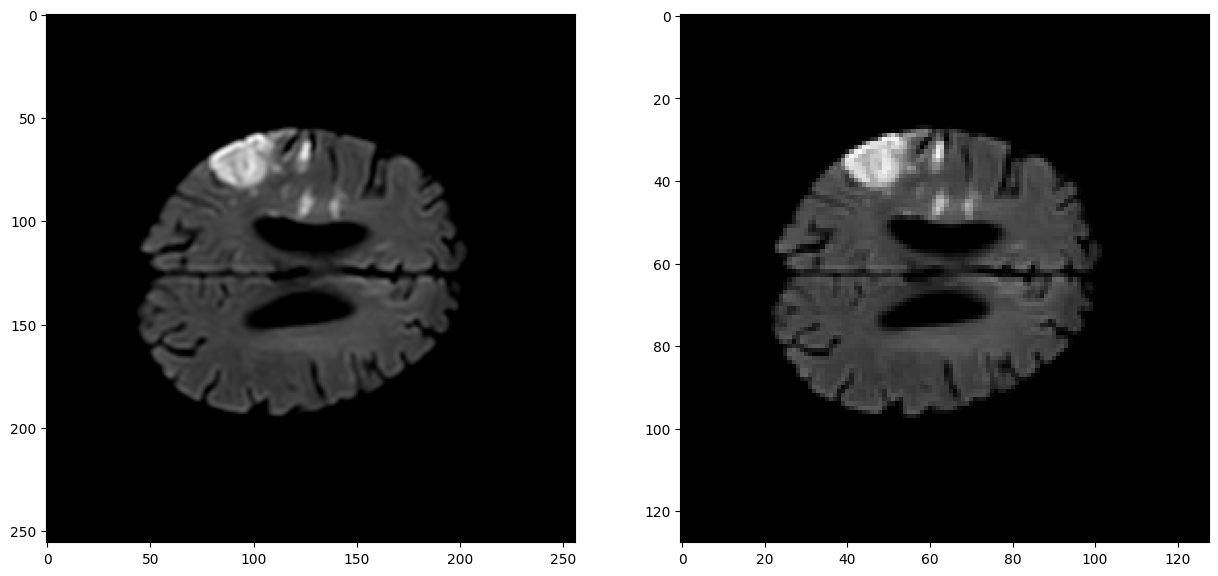

((256, 256), (128, 128))

In [14]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[:,:,sliceIndex]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

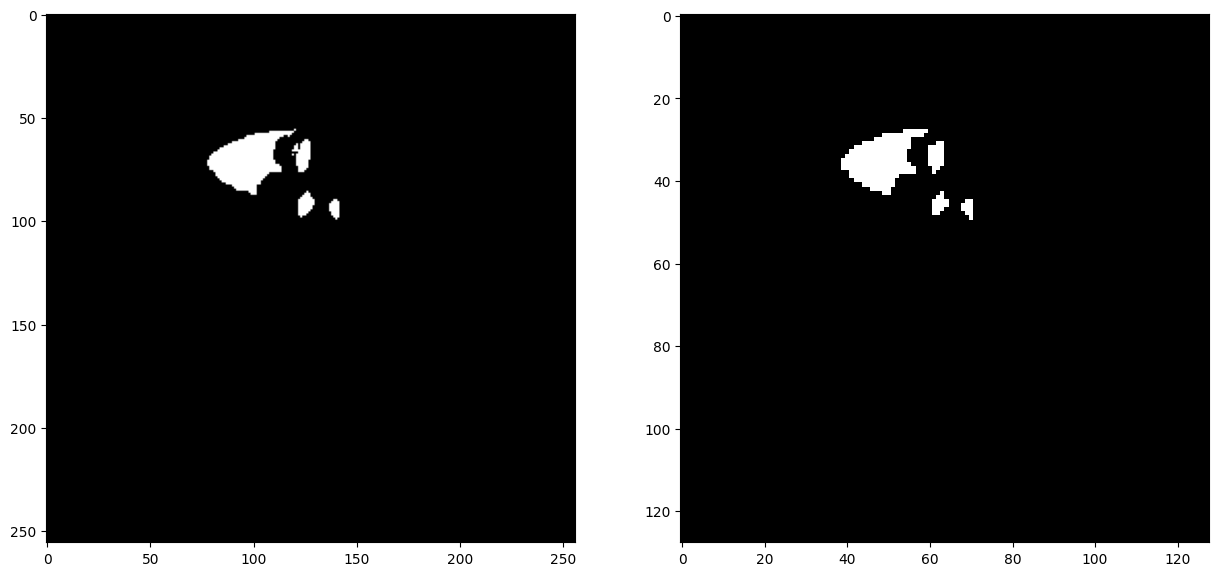

((256, 256), (128, 128))

In [15]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[:,:,sliceIndex]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

1/1 [==============================] - 5s 5s/step


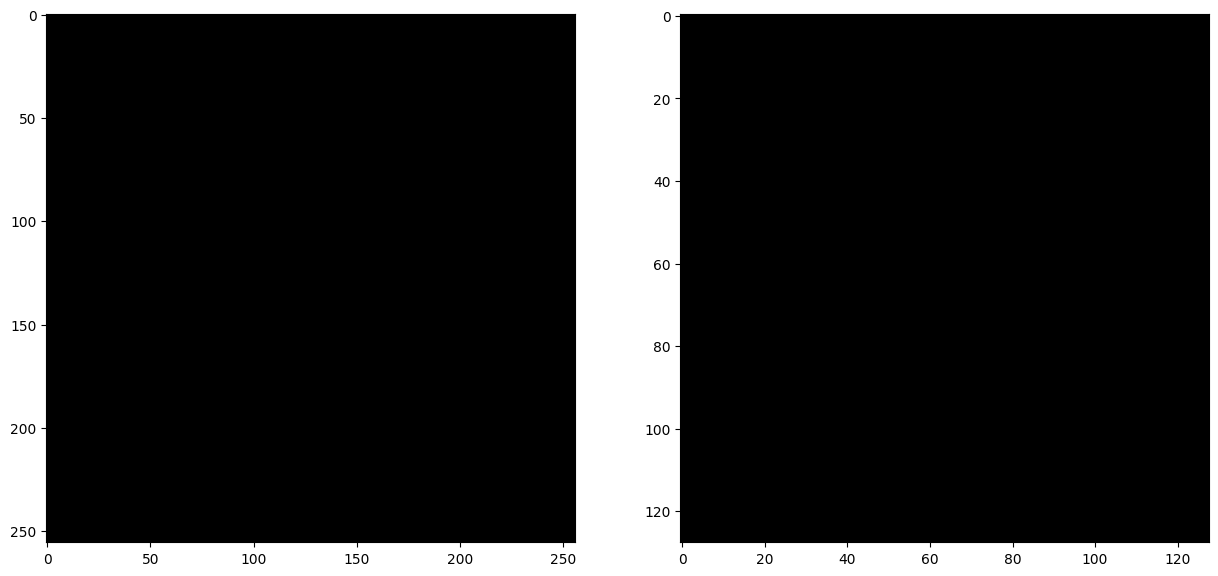

((256, 256), (128, 128))

In [16]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

In [17]:
imageInput.shape

(1, 128, 128, 1)

# Predicting a full volume

In [18]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.45] = 1.0
        outImg[outImg<=0.45] = 0.0
    return outImg

In [19]:
predImg = predictVolume(imgTarget)

1/1 [==============================] - 0s 23ms/step


# Calculate Volume


In [20]:
predImg.shape

(256, 256, 25)

In [21]:
imgTargetNii.shape

(256, 256, 25)

In [22]:
predImg.shape


(256, 256, 25)

In [23]:
imgMaskPixels = imgMask.sum()
imgMaskPixels

5185

In [24]:
predImagePixels = predImg.sum()
predImagePixels

0.0

In [25]:
from Voxel2Volume import voxel2volume

In [26]:
imgTargetNii = nib.load(targetImagePath)
voxel2volume(imgTargetNii, predImg)

0.0

In [27]:
voxel2volume(imgTargetNii, imgMask)

25.1117

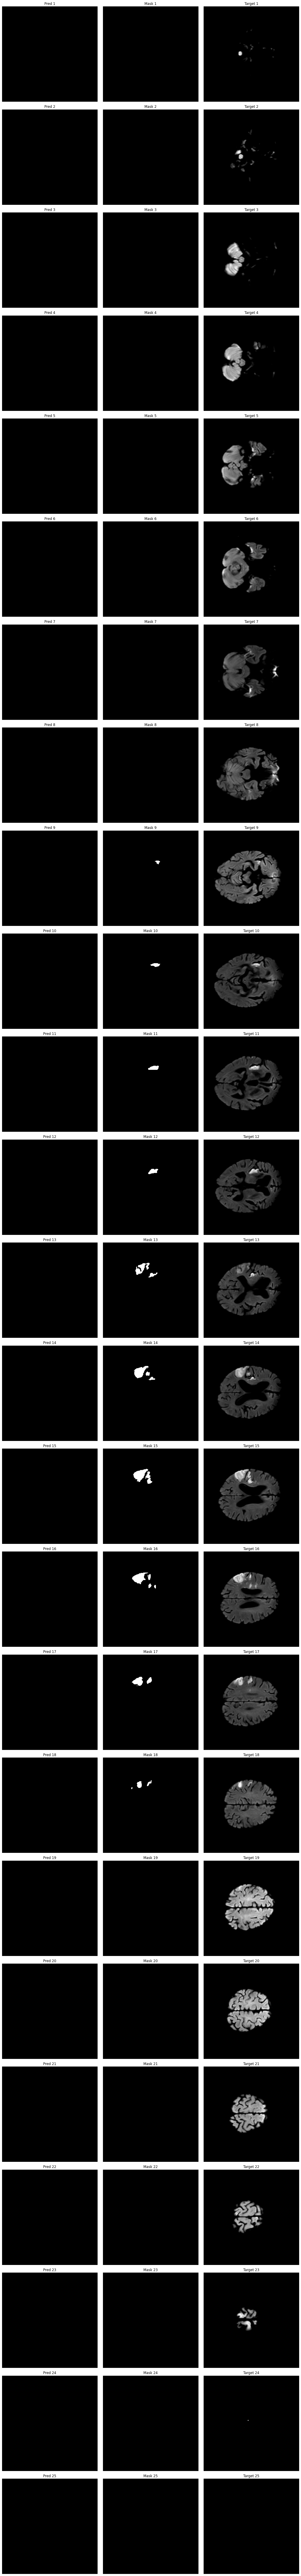

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 125))
for i in range(predImg.shape[2]):
    plt.subplot(predImg.shape[2], 3, 3*i + 1)
    plt.imshow(predImg[:,:,i], cmap='gray')
    plt.title(f'Pred {i+1}')
    plt.axis('off')
    
    plt.subplot(predImg.shape[2], 3, 3*i + 2)
    plt.imshow(imgMask[:,:,i], cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')
    
    plt.subplot(predImg.shape[2], 3, 3*i + 3)
    plt.imshow(imgTarget[:,:,i], cmap='gray')
    plt.title(f'Target {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()
